In [3]:
######################
## Import Libraries ##
######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from sklearn import metrics

##########################
## Import training data ##
##########################
# KKH data used for training and validation from 2007-2013
os.chdir('C:\\Users\\audre\\Desktop\\MRI Text Classification\\Datasets')
data_ACR = pd.read_csv('KKH_ACR_cleaned_v2.csv')              # label 1
data_non_ACR = pd.read_csv('KKH_non_ACR_cleaned_v2.csv')      # label 0
# Combining datasets
KKH_data = data_ACR[['No.', 'Indication for MRI', 'ACR/No ACR']].append(data_non_ACR[['No.', 'Indication for MRI', 'ACR/No ACR']], ignore_index = True)

text = []
y = []
for i in range(0, len(KKH_data)):
    sentence = KKH_data['Indication for MRI'][i]        
    sentence = re.sub('[^a-zA-Z]', ' ', str(sentence))     # replace non-alphabets with whitespace
    sentence = sentence.lower()
    text.append(sentence)
    label = KKH_data['ACR/No ACR'][i]
    y.append(label)

######################
## Import test data ##
######################
#Load new KKH data (2014-2017)
os.chdir('C:\\Users\\audre\\Desktop\\MRI Text Classification\\Datasets\\KKH_newdata(2014-2017)')
new_data = pd.read_excel('KKH_201401-201709 annonymised.xls', sheet_name = 'Export Worksheet')

# Data Cleaning 
new_data.dropna(subset = ['Follow_ACR'], how = 'any', inplace=True)    # remove NAs from the data
new_data = new_data.reset_index(drop = True)

for i in range(0, len(new_data)):
    sentence = new_data['Indication/History'][i]          
    sentence = re.sub('[^a-zA-Z]', ' ', str(sentence))       # replace non-alphabets with whitespace
    sentence = sentence.lower()                              # convert to lowercase
    text.append(sentence)
    label = new_data['Follow_ACR'][i]
    label = label.astype(int)
    y.append(label)

###############
## Tokenizer ##
###############
from keras.preprocessing.text import Tokenizer
import pickle
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # ignore these characters in the text
                     lower = True,                                       # convert to lowercase
                     split = ' ')                                        # split words by space
tokenizer.fit_on_texts(text)    # build tokenizer based on specified text
word_index = tokenizer.word_index
print('Found %d unique words.' % len(word_index))

with open('tokenizer_biowordvec_v2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(text)  # convert texts to sequences (vectors of integers)

######################
## Split Train-Test ##
######################  
X = sequences
y = y
# Spliting the dataset into the Training set and Validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training set: %d' % len(X_train))
print('Shape of val set: %d' % len(X_val))

Found 5624 unique words.
Shape of training set: 4144
Shape of val set: 1037


In [5]:
################
## Preprocess ##
################
# Padding: to make the sentences equal in length
from keras.preprocessing.sequence import pad_sequences
maxlen = 90
def pad(df):
    padded_sequences = pad_sequences(df, maxlen = maxlen)
    return padded_sequences
padded_train = pad(X_train)    # pad sequences in training set
padded_val = pad(X_val)

# One-hot encode y-values 
from keras.utils import to_categorical
# This step is not necessary if using 'sigmoid' as final activation.
encoded_train = to_categorical(y_train)           # encode y-values in training set
encoded_val = to_categorical(y_val)           # encode y-values in training set

In [6]:
#############################
## Loading word embeddings ##
#############################
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('C:\\Users\\audre\\Desktop\\MRI Text Classification\\bio_embedding_extrinsic', binary = True)
word_vectors = model.wv
print('Number of word vectors: %d' % len(word_vectors.vocab))

Number of word vectors: 2324849


C:\Users\audre\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [7]:
#############################
## Create embedding matrix ##
#############################
embed_dim = 200
max_features = len(word_index) + 1
wv_matrix = np.zeros((max_features, embed_dim))    # initialize the matrix
for word, i in word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_vector = word_vectors[word]       
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass

In [8]:
####################
## Training Model ##
####################
# Simple LSTM
from keras import optimizers
from keras.layers import Dense, LSTM, Embedding, Dropout, Flatten
from keras.layers import Bidirectional, MaxPooling1D
from keras.models import Sequential
from keras.metrics import binary_accuracy

embed_size = 200

model = Sequential()
model.add(Embedding(max_features, embed_size, weights = [wv_matrix], input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Flatten()) 
model.add(Dense(2, activation = 'softmax'))  
# If using sigmoid activation, replace line 13 with
# model.add(Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = optimizers.RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = [binary_accuracy])

# fit the model
batch_size = 32
lstm = model.fit(padded_train, encoded_train,
                 epochs = 200,
                 batch_size = batch_size,
                 validation_data = (padded_val, encoded_val))

# save the model
model.save('C:\\Users\\audre\\Desktop\\MRI Text Classification\\biowordvec_BiLSTM_model_v2.5.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 200)           1125000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 90, 64)            59648     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 45, 64)            24832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidi

4144/4144 [==============================] - 31s 7ms/step - loss: 0.3260 - binary_accuracy: 0.8682 - val_loss: 0.3096 - val_binary_accuracy: 0.8679
Epoch 37/200
4144/4144 [==============================] - 32s 8ms/step - loss: 0.3409 - binary_accuracy: 0.8622 - val_loss: 0.3026 - val_binary_accuracy: 0.8679
Epoch 38/200
4144/4144 [==============================] - 32s 8ms/step - loss: 0.3285 - binary_accuracy: 0.8583 - val_loss: 0.3036 - val_binary_accuracy: 0.8756
Epoch 39/200
4144/4144 [==============================] - 31s 8ms/step - loss: 0.3250 - binary_accuracy: 0.8646 - val_loss: 0.3012 - val_binary_accuracy: 0.8727
Epoch 40/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.3251 - binary_accuracy: 0.8627 - val_loss: 0.3016 - val_binary_accuracy: 0.8698
Epoch 41/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.3286 - binary_accuracy: 0.8622 - val_loss: 0.2986 - val_binary_accuracy: 0.8698
Epoch 42/200
4144/4144 [=======================

Epoch 87/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2909 - binary_accuracy: 0.8803 - val_loss: 0.2687 - val_binary_accuracy: 0.8843
Epoch 88/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2877 - binary_accuracy: 0.8866 - val_loss: 0.2684 - val_binary_accuracy: 0.8814
Epoch 89/200
4144/4144 [==============================] - 31s 8ms/step - loss: 0.2917 - binary_accuracy: 0.8772 - val_loss: 0.2633 - val_binary_accuracy: 0.8852
Epoch 90/200
4144/4144 [==============================] - 31s 8ms/step - loss: 0.2926 - binary_accuracy: 0.8736 - val_loss: 0.2654 - val_binary_accuracy: 0.8843
Epoch 91/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2836 - binary_accuracy: 0.8832 - val_loss: 0.2657 - val_binary_accuracy: 0.8852
Epoch 92/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2888 - binary_accuracy: 0.8764 - val_loss: 0.2642 - val_binary_accuracy: 0.8852
Epoch 93/200
4144/4144 [==========

4144/4144 [==============================] - 26s 6ms/step - loss: 0.2738 - binary_accuracy: 0.8875 - val_loss: 0.2416 - val_binary_accuracy: 0.8978
Epoch 138/200
4144/4144 [==============================] - 26s 6ms/step - loss: 0.2588 - binary_accuracy: 0.8941 - val_loss: 0.2443 - val_binary_accuracy: 0.8987
Epoch 139/200
4144/4144 [==============================] - 28s 7ms/step - loss: 0.2621 - binary_accuracy: 0.8945 - val_loss: 0.2407 - val_binary_accuracy: 0.8939
Epoch 140/200
4144/4144 [==============================] - 29s 7ms/step - loss: 0.2707 - binary_accuracy: 0.8917 - val_loss: 0.2456 - val_binary_accuracy: 0.8987
Epoch 141/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2648 - binary_accuracy: 0.8895 - val_loss: 0.2402 - val_binary_accuracy: 0.8978
Epoch 142/200
4144/4144 [==============================] - 31s 8ms/step - loss: 0.2700 - binary_accuracy: 0.8933 - val_loss: 0.2414 - val_binary_accuracy: 0.8997
Epoch 143/200
4144/4144 [=================

4144/4144 [==============================] - 31s 7ms/step - loss: 0.2497 - binary_accuracy: 0.8974 - val_loss: 0.2400 - val_binary_accuracy: 0.9045
Epoch 188/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2480 - binary_accuracy: 0.8938 - val_loss: 0.2309 - val_binary_accuracy: 0.9055
Epoch 189/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2471 - binary_accuracy: 0.8960 - val_loss: 0.2327 - val_binary_accuracy: 0.9084
Epoch 190/200
4144/4144 [==============================] - 31s 7ms/step - loss: 0.2539 - binary_accuracy: 0.8970 - val_loss: 0.2366 - val_binary_accuracy: 0.9026
Epoch 191/200
4144/4144 [==============================] - 31s 8ms/step - loss: 0.2514 - binary_accuracy: 0.8982 - val_loss: 0.2323 - val_binary_accuracy: 0.9084
Epoch 192/200
4144/4144 [==============================] - 32s 8ms/step - loss: 0.2379 - binary_accuracy: 0.9059 - val_loss: 0.2397 - val_binary_accuracy: 0.9045
Epoch 193/200
4144/4144 [=================

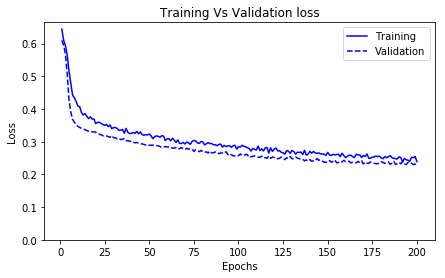

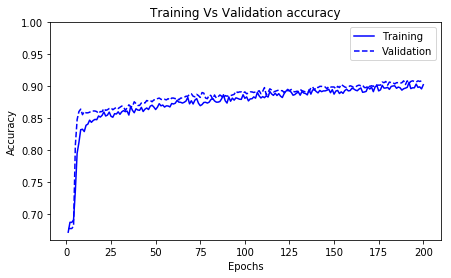

In [9]:
# plot losses
plt.figure(figsize = (7, 4))
ax = plt.subplot(111)                      # 111 means 1x1 grid, first subplot
train_loss = lstm.history['loss']          # retrieve training loss values
val_loss = lstm.history['val_loss']        # retrieve validation loss values
epochs = range(1, len(train_loss) + 1)
ax.plot(epochs, train_loss, 'b', label = 'Training')      # b means blue line
ax.plot(epochs, val_loss, 'b--', label = 'Validation')    # b-- means blue dashed line
plt.ylim(bottom = 0)
plt.title('Training Vs Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
ax.legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

# plot accuracy
plt.figure(figsize = (7, 4))
ax = plt.subplot(111)                               # 111 means 1x1 grid, first subplot
train_acc = lstm.history['binary_accuracy']         # retrieve training accuracy values
val_acc = lstm.history['val_binary_accuracy']       # retrieve validation accuracy values
epochs = range(1, len(train_acc) + 1)
ax.plot(epochs, train_acc, 'b', label = 'Training')      # b means blue line        
ax.plot(epochs, val_acc, 'b--', label = 'Validation')    # b-- means blue dashed line   
plt.ylim(top = 1)
plt.title('Training Vs Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
ax.legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

# If the loss increases and the accuracy increase too is because 
# your regularization techniques are working well and you're fighting the overfitting problem. 
# This is true only if the loss, then, starts to decrease whilst the accuracy continues to increase. 
# Otherwise, if the loss keep growing your model is diverging 
# and you should look for the cause (usually you're using a too high learning rate value).

In [10]:
# Predict 
import warnings
warnings.filterwarnings('ignore')

y_prob_lstm = model.predict(padded_val)    # predict probability of each validation set instance belonging to label 0 and 1
prob_1_val = []                         # create list to store all probabilities that instance is label 1
for i in y_prob_lstm:
    pred = i[1]                         # get the probability that the instance is label 1
    prob_1_val.append(pred)
y_pred_lstm = model.predict_classes(padded_val)   # predict the label of each validation set instance

# Metrics
print('Performance metrics - Validation set')
print('Accuracy: ', metrics.accuracy_score(y_val, y_pred_lstm))                   # accuracy
print('ROC-AUC score: ', metrics.roc_auc_score(y_val, prob_1_val))                # ROC-AUC score
cm_lstm = metrics.confusion_matrix(y_val, y_pred_lstm)                            # create confusion matrix
print('Confusion matrix: \n', cm_lstm)                                            # confusion Matrix
print('Specificity: ', cm_lstm[0,0]/(cm_lstm[0,0] + cm_lstm[0,1]))                # specificity
print('Precision: ', cm_lstm[1,1]/(cm_lstm[0,1] + cm_lstm[1,1]))                  # precision
print('Recall: ', cm_lstm[1,1]/(cm_lstm[1,0] + cm_lstm[1,1]))                     # recall
print('F1 score: ', metrics.f1_score(y_val, y_pred_lstm, average='binary'), '\n') # F1 Score

Performance metrics - Validation set
Accuracy:  0.9093539054966249
ROC-AUC score:  0.9638559340051878
Confusion matrix: 
 [[279  56]
 [ 38 664]]
Specificity:  0.8328358208955224
Precision:  0.9222222222222223
Recall:  0.9458689458689459
F1 score:  0.9338959212376934 

